# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        x, y = float(x), float(y)
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        x, y = float(x), float(y)
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
help(autograd.jacobian)

Help on function jacobian in module autograd.wrap_util:

jacobian(fun, argnum=0, *nary_op_args, **nary_op_kwargs)
    Returns a function which computes the Jacobian of `fun` with respect to
    positional argument number `argnum`, which must be a scalar or array. Unlike
    `grad` it is not restricted to scalar-output functions, but also it cannot
    take derivatives with respect to some argument types (like lists or dicts).
    If the input to `fun` has shape (in1, in2, ...) and the output has shape
    (out1, out2, ...) then the Jacobian has shape (out1, out2, ..., in1, in2, ...).



In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

type(grad_f(1.0, 0.0)) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

numpy.ndarray

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

#J_f = J(f)

J(f)(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

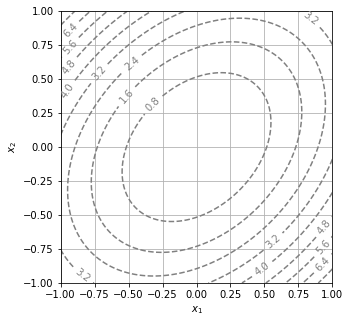

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

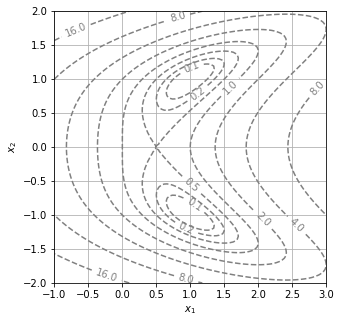

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

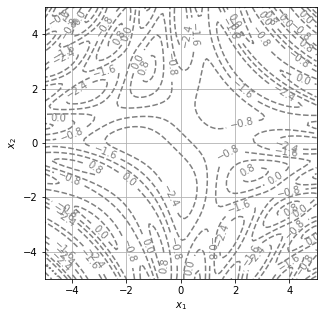

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

### Réponse
Cette application doit fournir une bonne approximation tout en sachant que le calcul avec flottant dans numpy conduit intrinsèquement rapidement à des erreurs d'arrondis.
Ainsi une valeur de l'ordre de 1e-3 ou 1e-4 devrait suffire.

In [14]:
N = 100
eps = 1e-4

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    Jac = J(F)
    
    for i in range(N):
        x, y = np.linalg.solve(Jac(x0, y0), -F(x0,y0)) + np.array([x0, y0]) 
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    raise ValueError(f"pas de convergence en {N} étapes.")

#on a préféré utiliser la fonction np.linal.solve moins gourmande en calcul qu'une inversion et une mutltiplication

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Réponse 
Ici, on fait varier la contrainte (chercher un point de la courbe de niveau sur la droite y = 4*x) et le point de départ.

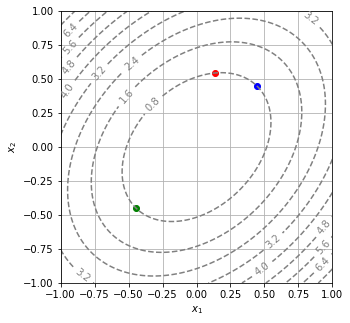

In [56]:
c = 0.8

def F1(x, y) :
    return np.array([f1(x, y) - c, x - y])

def F2(x,y) :
    return np.array([f1(x, y) - c, 4 * x -  y])

#version de display_contour qui permet d'afficher des points

def display_contourv2(f, x, y, levels) :
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
   
    
    #Newton avec différents
    x1, y1 = Newton(F1, 0.8, 0.8)
    x2, y2 = Newton(F2, 0.8, 0.8) #contrainte différente
    x3, y3 = Newton(F1, - 0.1, - 0.1) #point de départ différent
    plt.scatter(x1, y1, color = 'b') 
    plt.scatter(x2, y2, color = 'r') 
    plt.scatter(x3, y3, color = 'g') 
    
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")


display_contourv2(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = 10, 
)


#(0,447...; 0,447...) est bien un point de la courbe de niveau 0.8 de f1 tel que x1=x2 

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

### Réponse
Notre approche se base sur l'utilisation d'une fonction auxilliaire qui prend comme contraite la "minimisation de la distance" de la distance au "point de départ".


In [17]:
#codes "préliminaires"-----------------------#
def normalize(v):
    'v est un np.array'
    x1, x2 = v
    norme = np.sqrt(x1**2 + x2**2)
    return (1/norme)*v

def distance(u, v):
    x1, y1 = u
    x2, y2 = v
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#--------------------------------------------#

def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    c = f(x0, y0)
    
    points = []
    R = np.array([[0., 1.], [-1., 0.]]) # matrice de rotation d'angle -pi/2

    for _ in range (N):  
 
        def new_f(x,y):
            return np.array([f(x,y) - c, distance((x,y),(x0,y0)) - delta]) #fo,nction auxiliaire
        
        vect = normalize(grad(f)(x0, y0))
        vect = R.dot(vect) # vecteur unitaire 'à droite' du gradient 
        u, v = np.array([x0, y0]) + delta*vect
        x0, y0 = Newton(new_f, u, v)  
        points.append(np.array([x0,y0]))
    return points

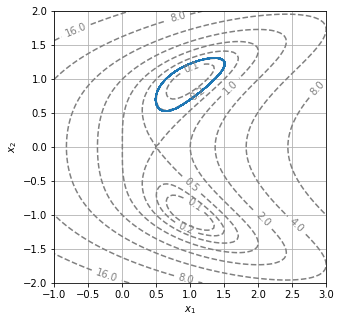

In [18]:
X, Y = [], []
liste =  np.array(level_curve(f2, 1, 0.7, N = 2000, delta = 0.05))
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(np.array(X), np.array(Y))
plt.axis([-1, 3, -2, 2])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

### Réponse
Il suffit de rajouter un test "d'auto-intersection"; si l'élément que l'on s'apprète à rajouter dans la liste est "trop près" du premier de liste, on considère avoir parcouru la ligne de niveau.

In [19]:
def level_curve1(f, x0, y0, delta=0.01, N=1000, eps=eps):
    
    c = f(x0, y0)
    
    points = []
    R = np.array([[0., 1.], [-1., 0.]]) # matrice de rotation d'angle -pi/2

    for i in range (N):  
 
        def new_f(x,y):
            return np.array([f(x,y) - c, distance((x,y),(x0,y0)) - delta])
        
        vect = normalize(grad(f)(x0, y0))
        vect = R.dot(vect) # vecteur unitaire 'à droite' du gradient 
        u, v = np.array([x0, y0]) + delta*vect
        x0, y0 = Newton(new_f, u, v)  
        if (i == 0) or (distance((x0, y0), points[0]) > delta): #test "d'auto-intersection"
            points.append(np.array([x0,y0]))
        else: 
            points.append(np.array([x0,y0]))
            return points
    return points

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

### Réponse
On vérifie que la longeur de la liste "points" en sortie ne dépend plus de N lorsqu'il devient assez grand pour "boucler" la courbe de niveau

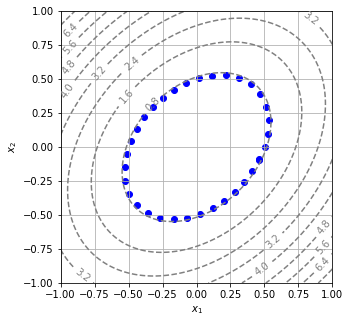

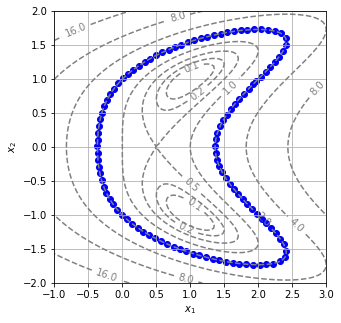

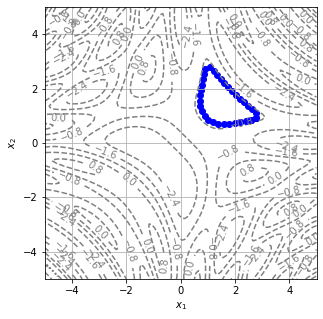

In [20]:
##Test pour f1
X, Y = [], []
liste =  np.array(level_curve1(f1, 0.5, 0, N = 200, delta = .1))
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.scatter(X, Y, color = 'b')
plt.show()


##Test pour f2
X, Y = [], []
liste =  np.array(level_curve1(f2, 2, 1, N = 200, delta = .1))
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.scatter(X, Y, color = 'b')
plt.show()


##Test pour f3
X, Y = [], []
liste =  np.array(level_curve1(f3, 2, 0.75, N = 200, delta = .2))
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.scatter(X, Y, color = 'b')
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [21]:
def area_squares(f, c, h, carré=[-1, 1, -1, 1]):
    A = 0
    l = []
    xmin, xmax, ymin, ymax = carré
    length = abs(xmax - xmin)
    N = int(np.ceil(length/h)) #on définit le nombre de case de dimension h*h du carré
    for i in range(N):
        for j in range(N):
            x = xmin + (i+1/2)*h
            y = ymin + (j+1/2)*h
            if f(x,y) <= c:
                A += h**2
                l.append([x,y])
    return A, l

## la liste en résultat permet de visualiser les points selectionnés par la fonction

In [22]:
def f4(x, y):
    return x**2 + y**2

3.141899999996012


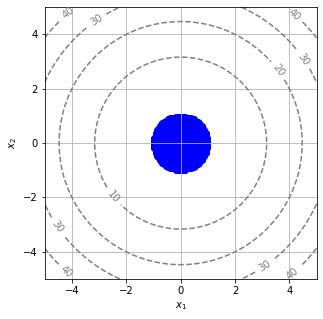

In [23]:
print(area_squares(f4, 1, 0.005)[0])
X, Y = [], []
liste =  np.array(area_squares(f4, 1, 0.05)[1])
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f4, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.scatter(X, Y, color = 'b')
plt.show()

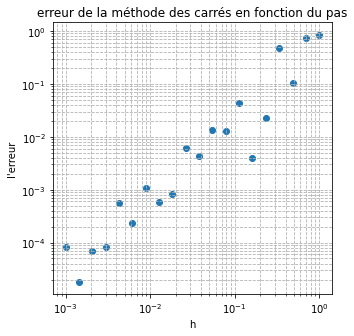

In [62]:
h_min = 10**(-3)
h_max = 1
n = 20

X = np.exp(np.linspace(np.log(h_min), np.log(h_max), n))
Y = np.abs(np.array([area_squares(f4, 1, h)[0] for h in X]) - np.pi)

plt.scatter(X, Y)
plt.xlabel("h")
plt.ylabel("l'erreur")
plt.xscale("log")
plt.yscale("log")
plt.grid(True,which="both", linestyle='--')
plt.title('erreur de la méthode des carrés en fonction du pas')
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


### Réponse
On peut modifier cette approche en testant l'appartenance ou non des cellules avoisinant une cellule en question à l'ensemble de niveau. En un certain sens, tester l'appartenance à "l'adhérence" et à "l'intérieur" de l'ensemble. On prend alors comme encadrement les aires de cette "frontière" et de cette "adhérence".

Ensuite, on définit une fonction encadrement qui utilise cette méthode pour déterminer un encadrement arbitrairement proche de la valeur "réelle".

In [ ]:
def encadrement_area_squares(f, c, h = 0.1, carré=[-1, 1, -1, 1]):
    
    min_area = 0
    maj_area = 0
    xmin, xmax, ymin, ymax = carré
    length = abs(xmax - xmin)
    N = int(np.ceil(length/h))
    for i in range(N):
        for j in range(N):
            x = xmin + (i+1/2)*h
            y = ymin + (j+1/2)*h
            #minoration, tous les carrés adjacents sont dans le sous niveau
            if (f(x, y) <= c) and (f(x - h, y) <= c) and (f(x + h, y) <= c) and (f(x, y - h) <= c) and (f(x, y + h) <= c):
                min_area += h**2
            #majoration, l'un des carrés adjacents est dans le sous niveau
            if (f(x, y) <= c) or (f(x - h, y) <= c) or (f(x + h, y) <= c) or (f(x, y - h) <= c) or (f(x, y + h) <= c):
                maj_area += h**2
    return min_area, maj_area



def encadrement(f, c, eps, N = 1, stop = 100, carré=[-1, 1, -1, 1]): #condition d'arrêt "manuelle"
    h = 0.1
    for _ in range(stop):
        min, max = area_squares_encadrement(f, c, h, carré=[-1, 1, -1, 1])
        if max - min < eps:
            return (f"{min} < area < {max} avec précision < {eps}")
        else:
            h = h/2 #dichotomie
    return (f"pas de convergence en {N} étapes")

##l'appel de la fonction "encadrement_area_squares" est extrêmement couteux en calcul, il fait 5 test par case. C'est une méthode pédestre qui nécessite des temps de calcul allant rapidement jusqu'à la minute.

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

### Réponse
Ici, on a privilégié une méthode de calcul d'aire signée avec le déterminant de part la manipulation très aisée de vecteurs du plan avec le module numpy.

In [63]:
def area_triangles(l, p):
    l = np.array(l)
    p = np.array(p)
    A = 0
    i = 0
    while i < len(l):
        z0 = l[i]
        z1 = l[(i+1) % len(l)]
        u = z1 - p
        v = z0 - p
        A += np.linalg.det(np.array([u, v]))/2 #formule de l'aire du triangle comme moitié de l'aire du prallélogramme associé
        i+=1
    return A
        

In [64]:
t = np.linspace(0, -2*np.pi, int(np.pi/np.arcsin(0.5/2)))
l = np.array([np.cos(t), np.sin(t)]).T

area_triangles(level_curve1(f4, 0, 1, delta=.05, N=200), (0, 0))
#area_triangles(level_curve1(f4, 0, 1, delta=.05, N=200) + area_triangles(level_curve1(f4, 0, -1, delta=.05, N=200), (5, 5)), (5, 5))

3.1402874572666475

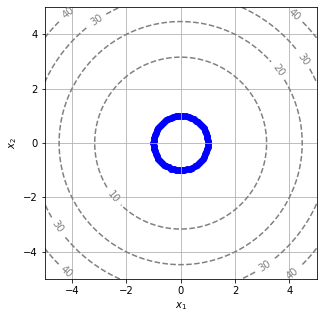

63


In [30]:
X, Y = [], []
liste =  np.array(level_curve1(f4, 0, 1, delta=.1, N=1000))
X = liste[:,0]
Y = liste[:,1]
display_contour(
    f4, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.scatter(X, Y, color = 'b')
plt.show()
print(len(liste))

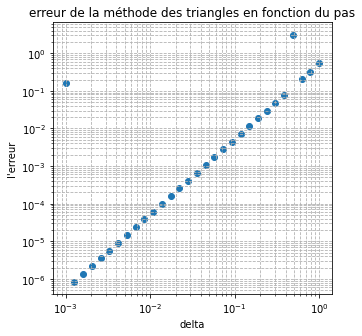

In [70]:
D = np.exp(np.linspace(np.log(10**(-3)), np.log(1), 30))  # liste de delta 
E = np.abs( np.array([area_triangles(level_curve1(f4, 0, 1, delta=d, N=5000), (0, 0)) for d in D]) - np.pi )

plt.scatter(D, E)
plt.xlabel("delta")
plt.ylabel("l'erreur")
plt.xscale("log")
plt.yscale("log")
plt.grid(True,which="both", linestyle='--')
plt.title('erreur de la méthode des triangles en fonction du pas')
plt.show()

In [ ]:
## nous n'avons pas pu expliquer les points ayant un écart de plusieurs ordres de grandeur aux voisins 

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

### Réponse

La méthode implémentée faisant appel à une aire signée convient bien.

In [33]:
area_triangles(level_curve1(f4, 0, 1, delta=.05, N=200), (5, 5))

3.1402874572666626

In [34]:
# La fonction reste cohérent même avec un point en dehors du cercle unité

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [35]:
T = np.arange(0, 2*np.pi, 0.05)
cercle_1 = [(np.cos(t)-2, np.sin(t)) for t in T]
cercle_2 = [(np.cos(t)+2, np.sin(t)) for t in T]
cercle_d = cercle_1 + cercle_2

area_triangles(cercle_d, (5, 5))  # return -6.28 le résultat semble cohérent

-6.280575375382341

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [36]:

T = area_triangles(level_curve1(f1, 0.5, 0, delta=.05, N=200), (5, 5))
C = area_squares(f1, 0.8, 2* 10**(-3))
print(T, C[0])

0.8317330086475688 0.8885760000008059


In [37]:
T = area_triangles(level_curve1(f2, 2, 1, N = 200, delta = .1), (0, 0))
C = area_squares(f2, 2, 2* 10**(-3), carré=[-1, 3, -2, 2])
print(T, C[0])

6.099564640956193 6.10476799985852


In [38]:
T = area_triangles(level_curve1(f3, 2, 0.75, N = 200, delta = .2), (0, 0))
C = area_squares(f3, -0.8, 2* 10**(-3), carré=[0.5, 3, 0.5, 3])
print(T, C[0])

-2.4818928758126195 2.9258760000007857


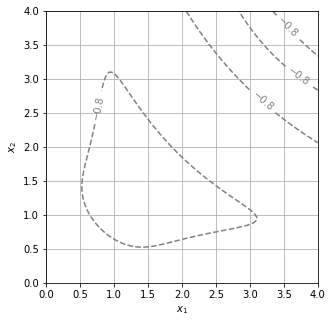

In [39]:
display_contour(
    f3, 
    x=np.linspace(0., 4.0, 100), 
    y=np.linspace(0., 4.0, 100), 
    levels=[-0.8], # 5 levels, automatically selected
)

# REPONSES

## La fonction area_square

On remarque avec la dernière exécution que la méthode des carrées est à la fois lente et restrictive pour calculer des aires de sous niveau. En effet, il faut que notre sous-niveau soit dans un carré défini comme variable de la fonction, ce qui suppose de connaître son emplacement. En revanche, si cette courbe est non convexe, cela ne pose aucun problème de calcul.

## La fonction area_triangles

La méthode des triangles est elle très pratique pour calculer l'aire d'une courbe de sous-niveau connexe par arcs à condition de pouvoir en trouver un point pour ensuite en délimiter le contour à l'aide de la fonction "level_curve1". 
De plus, cette méthode converge vite.
Cependant, si cette courbe n'est pas connexe par arcs, cela devient beaucoup plus difficile. Cela suppose de connaitre les composantes connexes par arcs de l'ensemble considéré ainsi qu'un point "proche" de chacune de ces composantes pour que la focntion "level_curve1" puisse en délimiter le contour. 
L'association entre ces deux fonctions ne semble donc pas adapté pour le calcul de sous-ensembles non connexes par arcs.